In [156]:
import imageio
import imgaug as ia
%matplotlib inline

image = imageio.imread('./tents/train/images/image1.png')


In [157]:
import imgaug as ia
ia.seed(1)
# imgaug uses matplotlib backend for displaying images
%matplotlib inline
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa 
# imageio library will be used for image input/output
import imageio
import pandas as pd
import numpy as np
import re
import os
import glob
# this library is needed to read XML files for converting it into CSV
import xml.etree.ElementTree as ET
import shutil

In [158]:
# load images as NumPy arrays and append them to images list
images = []
for index, file in enumerate(glob.glob('./tents/train/images/*.png')):
    images.append(imageio.imread(file))
    
# how many images we have
print('We have {} images'.format(len(images)))

We have 4 images


In [159]:
# what are the sizes of the images
for index, file in enumerate(glob.glob('./tents/train/images/*.png')):
    print('Image {} have size of {}'.format(file[7:], images[index].shape))

Image /train/images/image7.png have size of (1350, 2358, 4)
Image /train/images/image5.png have size of (1350, 2358, 4)
Image /train/images/image1.png have size of (1426, 1736, 4)
Image /train/images/image3.png have size of (1350, 2358, 4)


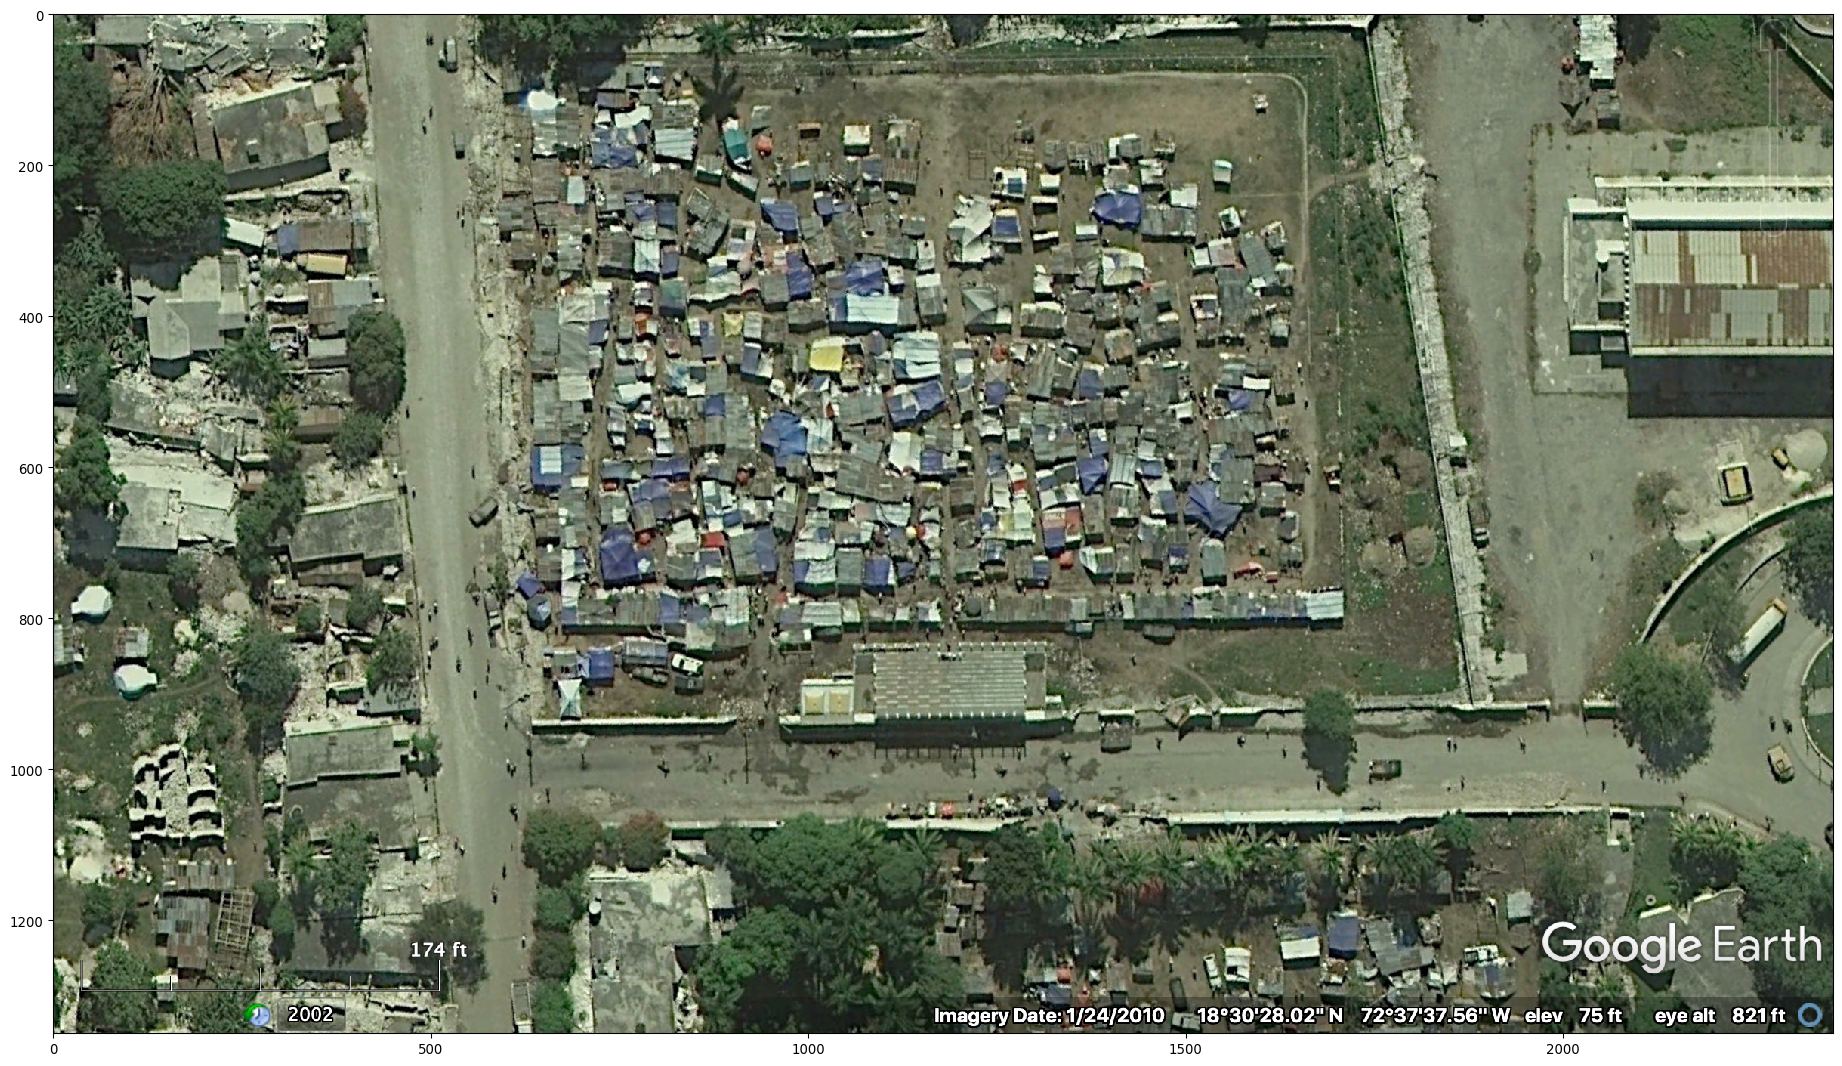

In [160]:
# Looking at the first image
ia.imshow(images[0])

Looking at the XML files.

In [161]:
# XML file names correspond to the image file names
for index, file in enumerate(glob.glob('./tents/train/annotations/*.xml')):
    print(file[1:])

/tents/train/annotations/image7.xml
/tents/train/annotations/image5.xml
/tents/train/annotations/image1.xml
/tents/train/annotations/image3.xml


In [162]:
image_1_3 = images[0]
image_1_3 = image_1_3[:,:,:3]

image_3_3 = images[1]
image_3_3 = image_3_3[:,:,:3]

image_5_3 = images[2]
image_5_3 = image_5_3[:,:,:3]

image_7_3 = images[3]
image_7_3 = image_7_3[:,:,:3]

In [163]:
image_1_3.shape

(1350, 2358, 3)

In [164]:
image_3_3.shape

(1350, 2358, 3)

In [165]:
image_5_3.shape

(1426, 1736, 3)

In [166]:
image_7_3.shape

(1350, 2358, 3)

In [167]:
from PIL import Image

image_1_3 = Image.fromarray(image_1_3)
image_1_3.save("image_1_3.png")
image_3_3 = Image.fromarray(image_3_3)
image_3_3.save("image_3_3.png")
image_5_3 = Image.fromarray(image_5_3)
image_5_3.save("image_5_3.png")
image_7_3 = Image.fromarray(image_7_3)
image_7_3.save("image_7_3.png")

In [41]:
# Function that will extract column data for our CSV file
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [42]:
# apply xml_to_csv() function to convert all XML files in images/ folder into labels.csv
labels_df = xml_to_csv('./tents/train/annotations/')
labels_df.to_csv(('labels.csv'), index=None)
print('Successfully converted xml to csv.')

Successfully converted xml to csv.


In [43]:
# let's see what's inside
# each bounding box has a separate row
labels_df

filename  width  height     class  xmin  ymin  xmax  ymax
0    image7.png   2358    1350      tent   998   433  1050   479
1    image7.png   2358    1350      tent   879   136   926   204
2    image7.png   2358    1350      tent   929   153   958   188
3    image7.png   2358    1350      tent   707   144   798   205
4    image7.png   2358    1350      tent   715   683   785   753
..          ...    ...     ...       ...   ...   ...   ...   ...
210  image3.png   2358    1350  not_tent  1009   794  1113   893
211  image3.png   2358    1350  not_tent   894   815  1002   885
212  image3.png   2358    1350  not_tent  1393   676  1620   821
213  image3.png   2358    1350  not_tent  1463   916  1545   994
214  image3.png   2358    1350  not_tent  1634   907  1733  1015

[215 rows x 8 columns]

In [44]:
# start by groupping each image bounding boxes coordinates
# separate dataframes are formed based on the filename
grouped = labels_df.groupby('filename')

In [45]:
group_df = grouped.get_group('image1.png')
group_df = group_df.reset_index()
group_df = group_df.drop(['index'], axis=1)
group_df

filename  width  height     class  xmin  ymin  xmax  ymax
0   image1.png   1736    1426      tent   459   793   491   827
1   image1.png   1736    1426      tent   158   221   190   250
2   image1.png   1736    1426      tent   413   732   441   758
3   image1.png   1736    1426      tent   676   527   699   554
4   image1.png   1736    1426      tent   765   517   790   540
..         ...    ...     ...       ...   ...   ...   ...   ...
74  image1.png   1736    1426  not_tent  1270  1018  1373  1163
75  image1.png   1736    1426  not_tent  1153  1133  1228  1189
76  image1.png   1736    1426  not_tent  1499   696  1586   903
77  image1.png   1736    1426  not_tent  1129  1253  1224  1370
78  image1.png   1736    1426  not_tent  1388  1149  1469  1275

[79 rows x 8 columns]

In [46]:
# get bounding boxes coordinates from grouped data frame and write into array        
bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
# display the array we've got
bb_array.shape

(79, 4)

In [47]:
bb_array[0]

array([459, 793, 491, 827])

In [50]:
images[0].shape

(1350, 2358, 4)

In [51]:
# pass the array of bounding boxes coordinates to the imgaug library
bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array,  shape=images[0].shape)

In [52]:
bbs[0]

BoundingBox(x1=459.0000, y1=793.0000, x2=491.0000, y2=827.0000, label=None)

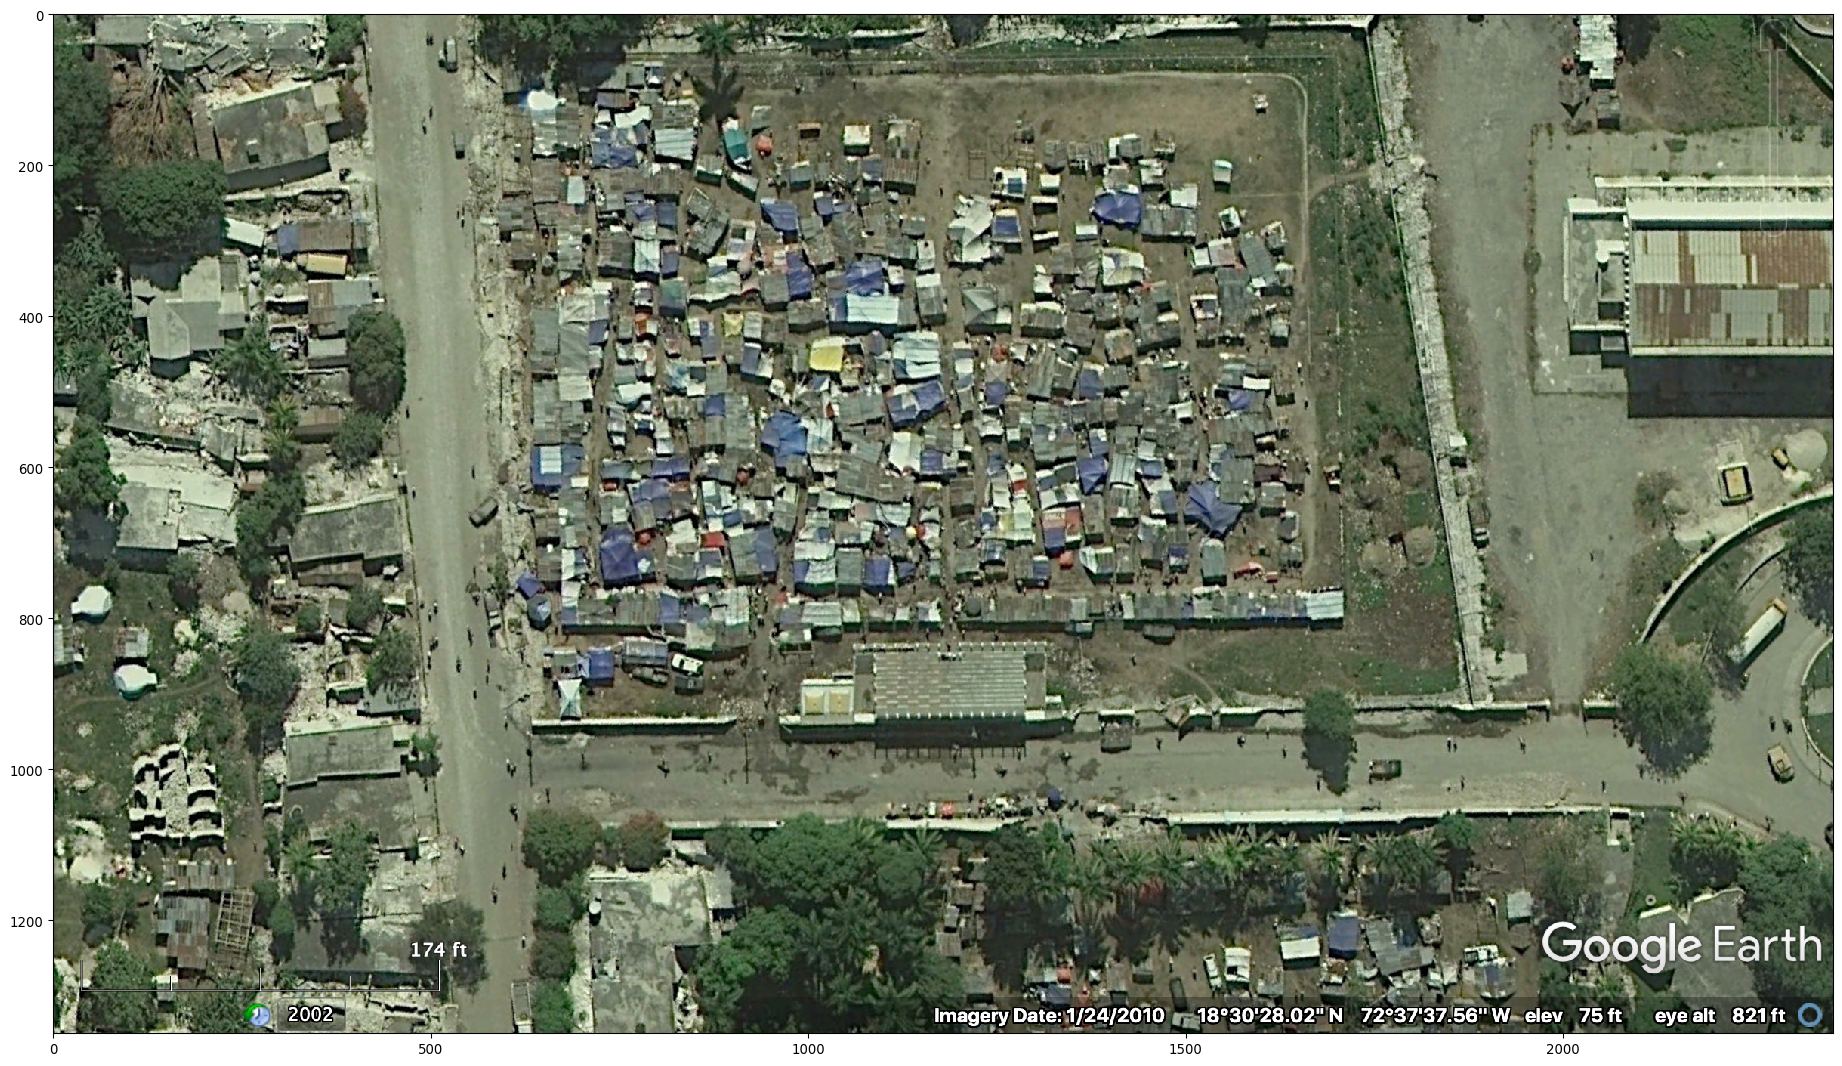

In [53]:
image1 = images[0]
image1 = image1[:,:,:3]
ia.imshow(image1)

In [28]:
image_1_3 = images[0]
image_1_3 = image_1_3[:,:,:3]
image_2_3 = images[1]
image_2_3 = image_2_3[:,:,:3]
image_3_3 = images[2]
image_3_3 = image_3_3[:,:,:3]
from PIL import Image
image_1_3 = Image.fromarray(image_1_3)
image_1_3.save("image_1_3.png")
image_2_3 = Image.fromarray(image_2_3)
image_2_3.save("image_2_3.png")
image_3_3 = Image.fromarray(image_3_3)
image_3_3.save("image_3_3.png")

In [54]:
# display the image and draw bounding boxes
ia.imshow(bbs[0].draw_on_image(images[0], size = 2))

ValueError: shape mismatch: value array of shape (3,) could not be broadcast to indexing result of shape (136,4)